### 0 Imports

If this code block is failing, make sure you have all of the necessary packages installed. See `requirements.txt` in the root directory for more information.

In [ ]:
import os
import json
import string
import numpy as np
from gensim.models import Word2Vec
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
from sklearn.metrics import jaccard_score
from itertools import combinations

### 1 Specify Target Directories and Variables

Make sure that `models_dir` points to where you have stored all of the models from the previous steps and `synonyms_dir` contains all of the saved synonym files from previous steps. Also make sure that there are no other files ending in `.model` in the `models_dir` directory that you do not want to be included in the processing as the mode will open all `.model` files. Likewise, ensure there are no files starting with `cleaned_` in `synonyms_dir` as they will all be opened for analysis. The analysis data and visuals created in this file will be saved to what you specify for `results_dir` and `visuals_dir` respectively.

In [19]:
models_dir = "../models"
synonyms_dir = "../synonyms"
results_dir = "../results"
visuals_dir = "../visualizations"

### 2 Similarity Analysis

This section looks into how similar synonyms are to the target word for every region model and synonym generation method. Step 0 and 1 are required for analysis in these steps. Also, before running this analysis, ensure that you have made all manual adjustments needed to the synonym data from the previous steps if any could not be decoded automatically. 

#### 2.1 Calculate Synonymy Scores for Each Model

This segment will use all of the generated data to calculate the average similarity for each synonym model and region pair as well as output an overall dataframe with all similarity scores. These are used for later visuals and statistical analysis. The average similarity and standard deviation for each synonym model and region pair is output to `{results_dir}/similarity_results.csv`. Every calculated similarity is stored in a dataframe in `{all_similarity_observations}/similarity_results.csv`.

In [ ]:
# Helper to put each word into the format it would be in in each model
def preprocess_word(word):
    word = word.lower()
    word = word.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    word = '_'.join(word.split())
    return word

similarity_scores = {}
similarity_stddevs = {}
all_observations = []

# Loop through every region model
for model_file in tqdm(os.listdir(models_dir)):
    if model_file.endswith('.model'):
        model_path = os.path.join(models_dir, model_file)
        
        # Load the Word2Vec model
        model = Word2Vec.load(model_path)
        region = model_file.split('.')[0]
        similarity_scores[region] = {}
        similarity_stddevs[region] = {}
        
        # Iterate over all synonym maps
        for synonym_file in os.listdir(synonyms_dir):
            if synonym_file.startswith('cleaned_') and synonym_file.endswith('.json'):
                synonym_path = os.path.join(synonyms_dir, synonym_file)
                method = synonym_file.split('_')[1]
                
                # Load the synonym map
                with open(synonym_path, 'r') as f:
                    synonym_map = json.load(f)
                
                # Collect per-key average similarities
                per_key_averages = []
                
                # Iterates over all target words and matching synomyns and calculates the average synonym similarity
                for target_word, synonyms in list(synonym_map.items()):
                    target_word = preprocess_word(target_word)
                    synonyms = [preprocess_word(syn) for syn in synonyms]
                    
                    if target_word in model.wv:
                        similarities = []
                        for synonym in synonyms:
                            if synonym in model.wv:
                                sim_score = model.wv.similarity(target_word, synonym)
                                similarities.append(sim_score)
                                
                                all_observations.append({
                                    'region': region,
                                    'method': method,
                                    'target_word': target_word,
                                    'synonym': synonym,
                                    'similarity': sim_score
                                })
                        
                        if similarities:
                            per_key_averages.append(np.mean(similarities))
                
                if per_key_averages:
                    average_similarity = np.mean(per_key_averages)
                    stddev_similarity = np.std(per_key_averages)                    
                    similarity_scores[region][method] = average_similarity
                    similarity_stddevs[region][method] = stddev_similarity
                else:
                    print(f"    No valid keys found for Region: {region}, Method: {method}")

records = []

for region in similarity_scores:
    for method in similarity_scores[region]:
        avg_similarity = similarity_scores[region][method]
        stddev_similarity = similarity_stddevs[region][method]
        records.append({
            'Region': region,
            'Method': method,
            'Avg_Similarity': avg_similarity,
            'Std_Deviation': stddev_similarity
        })

# Save all of the collected similarity data
results_df = pd.DataFrame(records)
results_df.to_csv(os.path.join(results_dir, 'similarity_results.csv'), index=False)
observations_df = pd.DataFrame(all_observations)
observations_df.to_csv(os.path.join(results_dir, 'all_similarity_observations.csv'), index=False)


100%|██████████| 39/39 [04:41<00:00,  7.22s/it]


#### 2.2 Visualizing Average Similarity by Model and Region

This segment generates a plot of average similarity scores for each region and model. The regions are displayed by circle of English with a dividing line dividing the output into inner, outer, and expanding English respectively. The graph is displayed when the code is run and also saved to `{visuals_dir}/similarity_scores_by_region_and_method.png`.

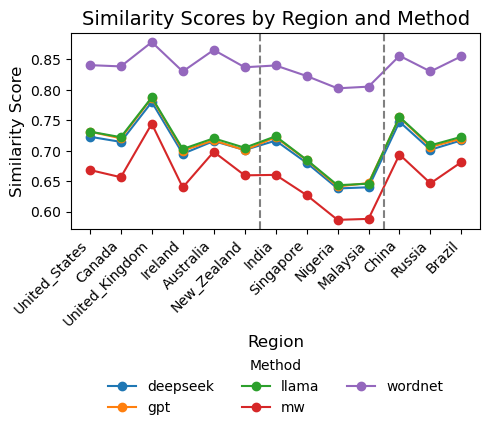

<Figure size 640x480 with 0 Axes>

In [ ]:
regions = [
    "United_States", "Canada", "United_Kingdom", "Ireland", "Australia", "New_Zealand",  # inner
    "India", "Singapore", "Nigeria", "Malaysia",  # outer
    "China", "Russia", "Brazil"  # expanding
]
methods = list(next(iter(similarity_scores.values())).keys())

plt.figure(figsize=(5, 6))

# prep data for plotting
for method in methods:
    scores = [similarity_scores[region][method] for region in regions]
    plt.plot(regions, scores, marker='o', label=method)

plt.xlabel('Region', fontsize=12)
plt.ylabel('Similarity Score', fontsize=12)
plt.title('Similarity Scores by Region and Method', fontsize=14)
plt.xticks(rotation=45, ha='right')

# vertical lines between groups
plt.axvline(x=5.5, color='gray', linestyle='--')
plt.axvline(x=9.5, color='gray', linestyle='--')

plt.legend(
    title='Method',
    loc='upper center',
    bbox_to_anchor=(0.5, -0.6),
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.show()
plt.savefig(os.path.join(visuals_dir, 'similarity_scores_by_region_and_method.png'), dpi=300, bbox_inches='tight')

#### 2.3 Visualizing Average Similarity by Model and Region (Separate Graphs)

This segment generates a plot of average similarity scores for each region and model. The regions are displayed by circle of English with a dividing line dividing the output into inner, outer, and expanding English respectively. This generates a graph for each model all in the same figure. This allows the average standard deviation of similarity to be added to the plots. The graph is displayed when the code is run and also saved to `{visuals_dir}/similarity_scores_by_region_and_method_with_error_bars.png`.

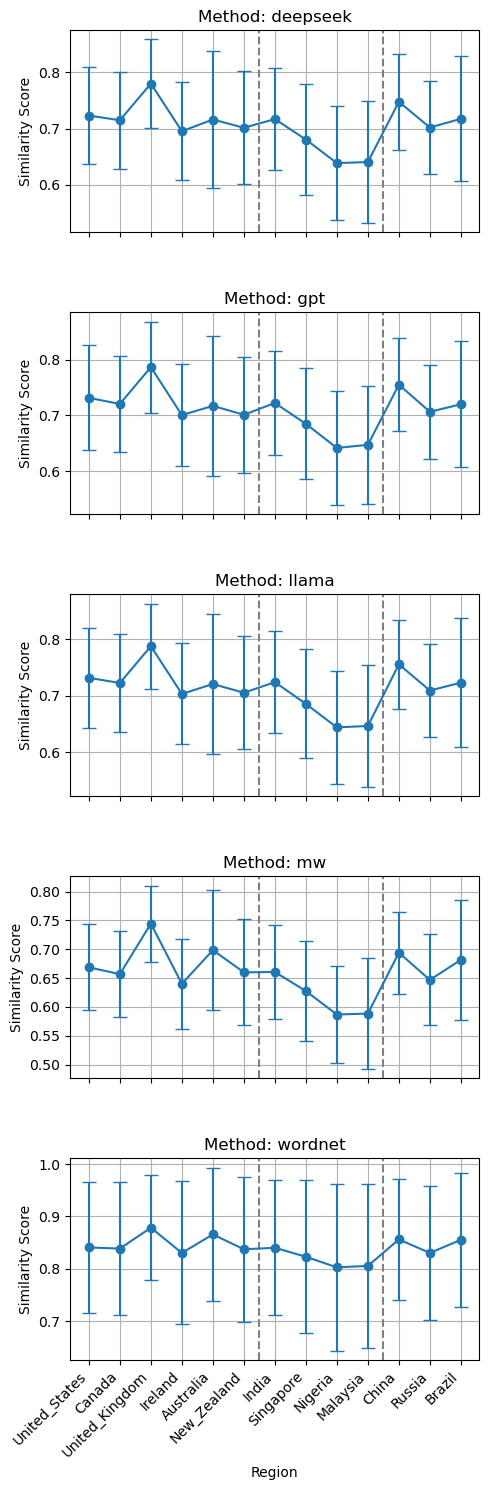

<Figure size 640x480 with 0 Axes>

In [ ]:
regions = [
    "United_States", "Canada", "United_Kingdom", "Ireland", "Australia", "New_Zealand",  # inner
    "India", "Singapore", "Nigeria", "Malaysia",  # outer
    "China", "Russia", "Brazil"  # expanding
]
methods = list(next(iter(similarity_scores.values())).keys())

# Create a tall figure with one subplot per method
fig, axes = plt.subplots(len(methods), 1, figsize=(5, 3 * len(methods)), sharex=True)

# If there's only one method, axes won't be a list
if len(methods) == 1:
    axes = [axes]

for ax, method in zip(axes, methods):
    scores = [similarity_scores[region][method] for region in regions]
    errors = [similarity_stddevs[region][method] for region in regions]

    # Plot with error bars
    ax.errorbar(regions, scores, yerr=errors, fmt='o-', capsize=5, label=method)

    # Add vertical lines between groups
    ax.axvline(x=5.5, color='gray', linestyle='--')
    ax.axvline(x=9.5, color='gray', linestyle='--')
    
    ax.set_ylabel('Similarity Score')
    ax.set_title(f'Method: {method}')
    ax.grid(True)

# Set common x-label
plt.xlabel('Region')
plt.xticks(rotation=45, ha='right')

# Adjust spacing
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)  # Space between subplots

# Show the plot
plt.show()
plt.savefig(os.path.join(visuals_dir, 'similarity_scores_by_region_and_method_with_error_bars.png'), dpi=300, bbox_inches='tight')

#### 2.4 Statistical Analysis

This section focuses on statistical tests of significance to determine if the differences in representations are statistically significant for our later discussion. For this part, it is necessary to run steps 0, 1, and 2.1 to generate the data but 2.2 and 2.3 are not needed. 

##### 2.4.1 Loading Data

First, we load the saved dataframe with all observed similarities from `{results_dir}/all_similarity_observations.csv`.

In [7]:
observations_df = pd.read_csv(os.path.join(results_dir, 'all_similarity_observations.csv'))
print(observations_df.head())


      region    method target_word   synonym  similarity
0  Australia  deepseek     swelled  expanded    0.677274
1  Australia  deepseek     swelled  enlarged    0.871160
2  Australia  deepseek     swelled  inflated    0.927393
3  Australia  deepseek     swelled   dilated    0.895251
4  Australia  deepseek     swelled   bloated    0.884583


##### 2.4.2 Overall ANOVA Test

Here we perform an ANOVA test across all of the data to observe if region has a statistically significant correlation with change in the similarity scores across **all models together**.

In [ ]:
region_data = observations_df[['region', 'similarity']]

# Perform ANOVA (one-way) by region
anova_result_region = stats.f_oneway(
    *[region_data[region_data['region'] == region]['similarity'] for region in region_data['region'].unique()]
)

print("ANOVA Results for Region Differences in Similarity Scores:")
print(f"F-statistic: {anova_result_region.statistic}")
print(f"P-value: {anova_result_region.pvalue}")


ANOVA Results for Region Differences in Similarity Scores:
F-statistic: 4219.614612590063
P-value: 0.0


Null Hypothesis (H0): There is no significant difference in similarity scores between regions.

Alternative Hypothesis (H1): At least one region's similarity score is significantly different from the others.

The p-value (0.0) is below 0.05, so we can reject the null hypothesis and conclude that there are significant differences in similarity scores between regions.

##### 2.4.3 Pairwise Tukey HSD Test for Overall Data

Because the results from 2.4.2 show that there is a statistically significant difference in similarity scores between regions, we can perform a pairwise test to see which regions specifically are statistically different and which are not. The output is saved to `{results_dir}/overall_tukey_region_results.txt`. The 'reject' column of the results is True when the regions are significantly different and False when the regions are not significantly different.

In [15]:
tukey_region = pairwise_tukeyhsd(endog=region_data['similarity'], groups=region_data['region'], alpha=0.05)
print("Post-hoc Tukey Test Results for Regions:")
print(tukey_region)

with open(os.path.join(results_dir, 'overall_tukey_region_results.txt'), 'w') as f:
    f.write(str(tukey_region))

Post-hoc Tukey Test Results for Regions:
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
     Australia         Brazil  -0.0017 0.9096  -0.005  0.0017  False
     Australia         Canada  -0.0216    0.0 -0.0248 -0.0183   True
     Australia          China   0.0165    0.0  0.0133  0.0198   True
     Australia          India  -0.0213    0.0 -0.0245  -0.018   True
     Australia        Ireland  -0.0443    0.0 -0.0475  -0.041   True
     Australia       Malaysia  -0.0923    0.0 -0.0956  -0.089   True
     Australia    New_Zealand  -0.0391    0.0 -0.0424 -0.0358   True
     Australia        Nigeria  -0.1025    0.0 -0.1058 -0.0992   True
     Australia         Russia  -0.0332    0.0 -0.0365   -0.03   True
     Australia      Singapore  -0.0601    0.0 -0.0634 -0.0569   True
     Australia United_Kingdom   0.0569    0.0  0.0536  0.0601 

##### 2.4.4 ANOVA Test by Synonym Model

Here we perform an ANOVA test for the data split by synonym model to observe if region has a statistically significant correlation with change in the similarity scores generated by each synonym model individually.

In [11]:
def run_anova_by_method(observations_df):
    results = {}
    
    # Get unique methods from the dataframe
    methods = observations_df['method'].unique()
    
    for method in methods:
        # Filter data for the specific method
        method_data = observations_df[observations_df['method'] == method]
        
        # Group the data by region
        region_data = method_data[['region', 'similarity']]
        
        # Perform ANOVA (one-way) by region
        anova_result = stats.f_oneway(
            *[region_data[region_data['region'] == region]['similarity'] for region in region_data['region'].unique()]
        )
        
        # Store the result in the results dictionary
        results[method] = {
            'F-statistic': anova_result.statistic,
            'p-value': anova_result.pvalue
        }
        
    return results

# Example usage:
anova_results = run_anova_by_method(observations_df)

# Print the ANOVA results for each method
for method, result in anova_results.items():
    print(f"ANOVA Results for Method: {method}")
    print(f"    F-statistic: {result['F-statistic']}")
    print(f"    P-value: {result['p-value']}")
    print("-" * 50)


ANOVA Results for Method: deepseek
    F-statistic: 696.1234691507484
    P-value: 0.0
--------------------------------------------------
ANOVA Results for Method: gpt
    F-statistic: 497.99714940616894
    P-value: 0.0
--------------------------------------------------
ANOVA Results for Method: llama
    F-statistic: 627.6424381720823
    P-value: 0.0
--------------------------------------------------
ANOVA Results for Method: mw
    F-statistic: 2941.7541491867587
    P-value: 0.0
--------------------------------------------------
ANOVA Results for Method: wordnet
    F-statistic: 175.6115088871341
    P-value: 0.0
--------------------------------------------------


##### 2.4.5 Pairwise Tukey HSD Test by Synonym Model

Because the results from 2.4.3 show that there is a statistically significant difference in similarity scores between regions for every synonym model, we can perform a pairwise test to see which regions specifically are statistically different and which are not. The output is saved by synonym model to `{results_dir}/{model}_tukey_region_results.txt`. The 'reject' column of the results is True when the regions are significantly different and False when the regions are not significantly different.

In [17]:
for method in observations_df['method'].unique():
    curr_data = observations_df[observations_df['method'] == method]
    region_data = curr_data[['region', 'similarity']]
    tukey_region = pairwise_tukeyhsd(endog=region_data['similarity'], groups=region_data['region'], alpha=0.05)

    with open(os.path.join(results_dir, f'{method}_tukey_region_results.txt'), 'w') as f:
        f.write(str(tukey_region))

### 3 Jaccard Similarity Analysis

In this section, we look at all of the lists of generated synonyms, and calculate Jaccard similarity for each pairing of synonym models for each target word and average across all 1000 samples. This is then visualized.

#### 3.1 Caculate Pairwise Average Jaccard Similarity

The model pairwise Jaccard similarity is calculated and saved to `{results_dir}/jaccard_similarity_results.csv`.

In [ ]:
jaccard_results = []

# Iterate over synonym files in the synonyms directory
for synonym_file in os.listdir(synonyms_dir):
    if synonym_file.startswith('cleaned_') and synonym_file.endswith('.json'):
        synonym_path = os.path.join(synonyms_dir, synonym_file)
        method = synonym_file.split('_')[1]
        
        # Load the synonym map
        with open(synonym_path, 'r') as f:
            synonym_map = json.load(f)
        
        # Iterate over each word in the synonym map
        for word, synonyms in synonym_map.items():
            # Preprocess the word and synonyms
            word = preprocess_word(word)
            synonyms = set(preprocess_word(syn) for syn in synonyms)
            
            # Check if the word already exists in the results
            existing_entry = next((entry for entry in jaccard_results if entry['Word'] == word), None)
            
            if existing_entry:
                # Update the existing entry with the current method's synonyms
                existing_entry[method] = synonyms
            else:
                # Create a new entry for the word
                jaccard_results.append({'Word': word, method: synonyms})

# Calculate Jaccard similarity for every pair of methods
final_results = []
for entry in jaccard_results:
    word = entry.pop('Word')
    methods = list(entry.keys())
    
    for method1, method2 in combinations(methods, 2):
        set1 = entry[method1]
        set2 = entry[method2]
        
        # Calculate Jaccard similarity
        if set1 or set2:  # Avoid division by zero
            jaccard_sim = len(set1 & set2) / len(set1 | set2)
        else:
            jaccard_sim = 0.0
        
        # Append the result
        final_results.append({
            'Word': word,
            'Method1': method1,
            'Method2': method2,
            'Jaccard_Similarity': jaccard_sim
        })

# Convert results to a DataFrame
jaccard_df = pd.DataFrame(final_results)

# Save the results to a CSV file
jaccard_df.to_csv(os.path.join(results_dir, 'jaccard_similarity_results.csv'), index=False)

print("Jaccard similarity results saved successfully.")

Jaccard similarity results saved successfully.


#### 3.2 Pairwise Average Jaccard Visualized

In this segment, the pairwise Jaccard Similarity is visualized to clearly see the overlap between models. This graphic is saved to `{visuals_dir}/jaccard_similarity_heatmap.png`.

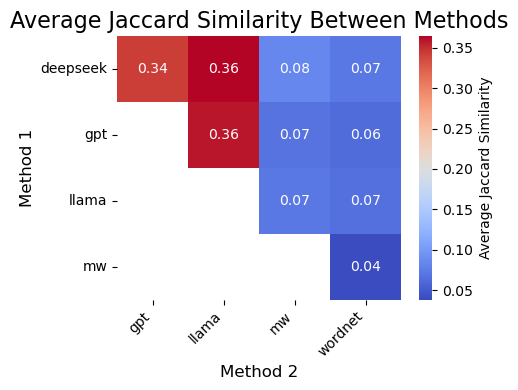

In [ ]:
jaccard_df = pd.read_csv(os.path.join(results_dir, 'jaccard_similarity_results.csv'))
average_jaccard = jaccard_df.groupby(['Method1', 'Method2'])['Jaccard_Similarity'].mean().unstack()
average_jaccard = average_jaccard.fillna(0)
mask = average_jaccard == 0

plt.figure(figsize=(5, 4))
sns.heatmap(average_jaccard, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Average Jaccard Similarity'},
            mask=mask, annot_kws={"color": "white"})

plt.title('Average Jaccard Similarity Between Methods', fontsize=16)
plt.xlabel('Method 2', fontsize=12)
plt.ylabel('Method 1', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Show the plot
plt.tight_layout()
plt.show()
plt.savefig(os.path.join(visuals_dir, 'jaccard_similarity_heatmap.png'), dpi=300, bbox_inches='tight')